### Library Import

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sktime

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.performance_metrics.forecasting import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
)
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

from sktime.utils import plotting


from sklearn.linear_model import (
    LinearRegression,
    ElasticNetCV,
    MultiTaskElasticNetCV,
    MultiTaskElasticNet,
    RidgeCV,
    LassoCV,
    HuberRegressor,
)
from sklearn.multioutput import MultiOutputRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from lerner.sanity import *

In [2]:
np.random.seed(80)

plt.style.use("seaborn-v0_8-darkgrid")

sktime.__version__

'0.18.0'

In [3]:
csv_path = "./jena_climate_2009_2016.csv"
columns = [
    "Date Time",
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
]

dataframe = (
    load_data(csv_path)
    .pipe(select_column, columns)
    .pipe(create_index, "Date Time", format="%d.%m.%Y %H:%M:%S")
    .pipe(resample_Data, "D")
    .pipe(replace_null)
    # .pipe(drop_indicies)
)

print(f"Shape {dataframe.shape}")
dataframe.head()

load_data: DF Shape (420551, 15)
select_column: DF Shape (420551, 10)
format_datetime: DF Shape (420551, 9)
resample_Data: DF Shape (2923, 9)
replace_null: DF Shape (2923, 9)
Shape (2923, 9)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol)
Index,,,,,,,,,
2009-01-01,999.67,-4.58,268.61,-5.62,92.4,4.34,0.33,2.50,4.02
2009-01-02,1002.35,-4.59,268.39,-6.03,89.6,4.34,0.45,2.42,3.88
2009-01-03,993.05,-1.90,271.80,-6.46,70.8,5.31,1.55,2.36,3.79
2009-01-04,985.12,-1.50,272.83,-2.48,93.0,5.47,0.38,3.22,5.16
2009-01-05,997.51,-12.54,260.81,-15.01,81.6,2.32,0.43,1.18,1.90


In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2009-01-01 to 2017-01-01
Freq: D
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p (mbar)         2923 non-null   float64
 1   T (degC)         2923 non-null   float64
 2   Tpot (K)         2923 non-null   float64
 3   Tdew (degC)      2923 non-null   float64
 4   rh (%)           2923 non-null   float64
 5   VPmax (mbar)     2923 non-null   float64
 6   VPdef (mbar)     2923 non-null   float64
 7   sh (g/kg)        2923 non-null   float64
 8   H2OC (mmol/mol)  2923 non-null   float64
dtypes: float64(9)
memory usage: 228.4 KB


### Forcasting all Columns single step [ Ignore]

(2899, 9) (24, 9)


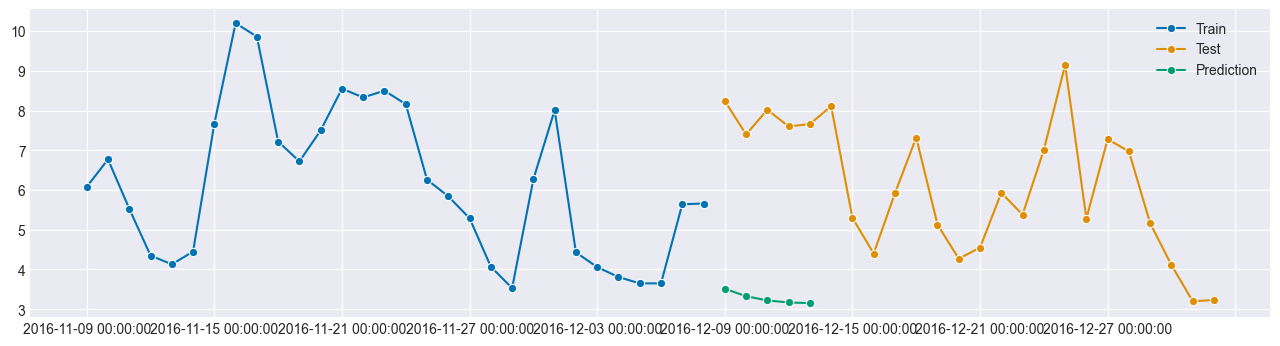

In [5]:
train_y, test_y = temporal_train_test_split(dataframe, test_size=24)

print(train_y.shape, test_y.shape)

target_column = ["H2OC (mmol/mol)"]
feat_column = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPdef (mbar)",
]

# regressor = LinearRegression(fit_intercept=False)
regressor_e = ElasticNetCV(n_alphas=30, fit_intercept=False, cv=10)

regressor_r = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10], cv=10, fit_intercept=False)

forecaster = make_reduction(
    regressor_r,
    # transformers=StandardScaler(),
    window_length=15,
    strategy="recursive",
)

forecaster.fit(train_y)
y_predict = forecaster.predict(fh=np.arange(1, 6))

fig, ax = plotting.plot_series(
    train_y[target_column].tail(30),
    test_y[target_column],
    y_predict[target_column],
    labels=["Train", "Test", "Prediction"],
)

### Test Train Split For Singel Columns Multistep + Multivariate Forcasting

In [6]:
target_column = ["H2OC (mmol/mol)"]
feat_column = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPdef (mbar)",
]
input_seq_len = 30
ouput_seq_len = 24

y_train, y_test, x_train, x_test = temporal_train_test_split(
    dataframe[target_column], dataframe[feat_column], test_size=ouput_seq_len
)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(2899, 7) (2899, 1) (24, 7) (24, 1)


### Model Prepattion and Training

In [7]:
regressor = LinearRegression(fit_intercept=False)

regressor_e = MultiTaskElasticNet(
    fit_intercept=False,
    max_iter=5000,
    selection="random",
)

regressor_r = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10], cv=10, fit_intercept=False)

regressor_h = MultiOutputRegressor(
    make_pipeline(StandardScaler(), HuberRegressor(fit_intercept=False, max_iter=10000))
)

# fhzon = ForecastingHorizon(y_test.index, is_relative=False)
# fhzon = np.arange(1,len(y_test)+1)
fhzon = np.arange(ouput_seq_len) + 1

forecaster = make_reduction(
    regressor_r,
    # transformers=StandardScaler(),
    window_length=input_seq_len,
    strategy="multioutput",
)

forecaster_pipe = TransformedTargetForecaster(
    [
        ("trnsformer", TabularToSeriesAdaptor(StandardScaler())),
        ("forecaster", forecaster),
    ]
)

forecaster_pipe.fit(y_train, X=x_train, fh=fhzon)

TransformedTargetForecaster(steps=[('trnsformer',
                                    TabularToSeriesAdaptor(transformer=StandardScaler())),
                                   ('forecaster',
                                    MultioutputTabularRegressionForecaster(estimator=RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=10, fit_intercept=False),
                                                                           window_length=30))])

### Prediction on Test Data

In [18]:
print(f"forecaster.cutoff After Traing Before Predict : {forecaster.cutoff}")

y_predict = forecaster_pipe.predict(fh=fhzon)

print(f"forecaster.cutoff After Traing + Predict : {forecaster.cutoff}")
# y_predict.head()

forecaster.cutoff After Traing Before Predict : None
forecaster.cutoff After Traing + Predict : None


### Plot Test Predictions

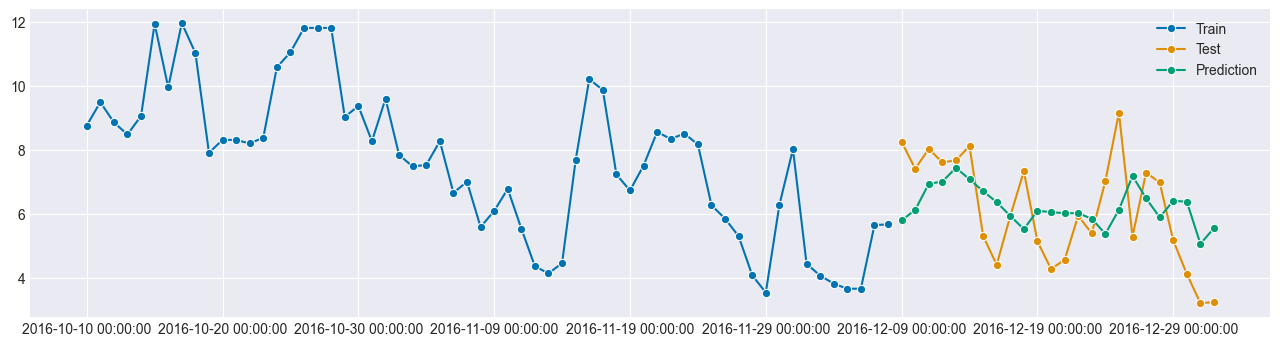

In [19]:
fig, ax = plotting.plot_series(
    y_train.tail(60), y_test, y_predict, labels=["Train", "Test", "Prediction"]
)

### Training Score

In [21]:
cross_validation = SlidingWindowSplitter(
    initial_window=int(y_train.shape[0] * 0.8),
    window_length=input_seq_len + ouput_seq_len,
    step_length=3,
)
losses = [MeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()]

results = evaluate(
    forecaster=forecaster, y=y_train, X=x_train, cv=cross_validation, scoring=losses
)

results[
    [
        "test_MeanSquaredError",
        "test_MeanAbsoluteError",
        "test_MeanAbsolutePercentageError",
    ]
].mean()

test_MeanSquaredError               5.072163
test_MeanAbsoluteError              1.736718
test_MeanAbsolutePercentageError    0.173806
dtype: float64

### Test Score

In [22]:
for loss in losses:
    l = loss(y_test, y_predict)
    print(f"{loss.name} : {l}")

MeanSquaredError : 2.441093851848592
MeanAbsoluteError : 1.363790075633134
MeanAbsolutePercentageError : 0.25416097205681537


### Forecasting

In [24]:
print(f"forecaster.cutoff After Traing + Predict{forecaster.cutoff}")

y_fcasted = forecaster_pipe.update(y_test, X=x_test, update_params=False)

print(f"forecaster.cutoff After Traing + Predict {forecaster.cutoff}")

y_fcasted = forecaster_pipe.predict(fh=fhzon)
y_fcasted.head()

forecaster.cutoff After Traing + PredictNone
forecaster.cutoff After Traing + Predict None


,H2OC (mmol/mol)
2017-01-02,3.930588
2017-01-03,4.107909
2017-01-04,4.029624
2017-01-05,4.037656
2017-01-06,3.982261


### Plot Forecasting

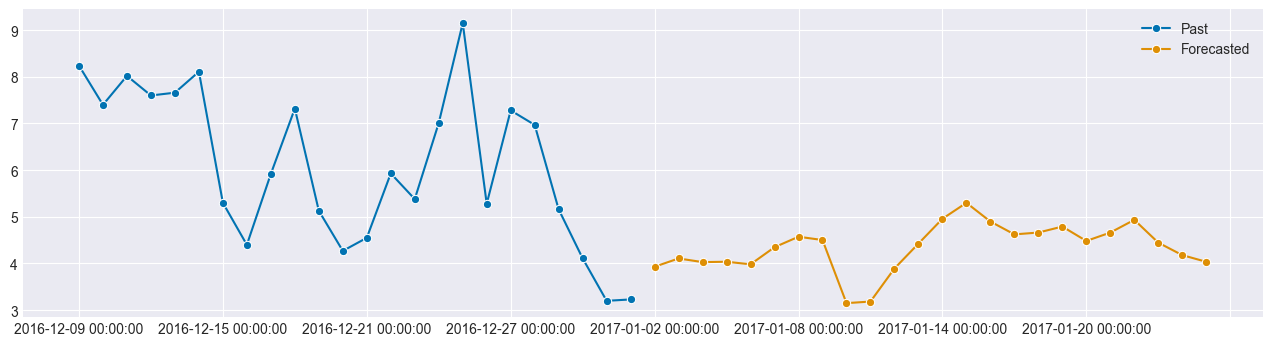

In [25]:
fig, ax = plotting.plot_series(y_test, y_fcasted, labels=["Past", "Forecasted"])